In [1]:
pip install google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cachetools-6.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Day 1b - Agent Architectures")


**Import ADK components**

Now, import the specific components you'll need from the Agent Development Kit and the Generative AI library. This keeps your code organized and ensures we have access to the necessary building blocks.

In [4]:
from google.adk.agents import Agent , SequentialAgent , ParallelAgent, LoopAgent

from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

print("✅ ADK components imported successfully.")





✅ ADK components imported successfully.


**Configure Retry Options**

When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [5]:
retry_config = types.HttpRetryOptions(
    attempts =5, # Maximum  retry attemts
    exp_base = 7, # delay multiplier
    initial_delay = 1,
    http_status_codes=[429, 500, 503, 504], # Retry on these HTTP errors
)

**Section 2: Why Multi-Agent Systems? + Your First Multi-Agent**

Single agents can do a lot. But what happens when the task gets complex? A single "monolithic" agent that tries to do research, writing, editing, and fact-checking all at once becomes a problem. Its instruction prompt gets long and confusing. It's hard to debug (which part failed?), difficult to maintain, and often produces unreliable results



**Solution: A Team of Specialists**

Instead of one "do-it-all" agent, we can build a multi-agent system. This is a team of simple, specialized agents that collaborate, just like a real-world team. Each agent has one clear job (e.g., one agent only does research, another only writes). This makes them easier to build, easier to test, and much more powerful and reliable when working together.

**Architecture: Single Agent vs Multi-Agent Team**

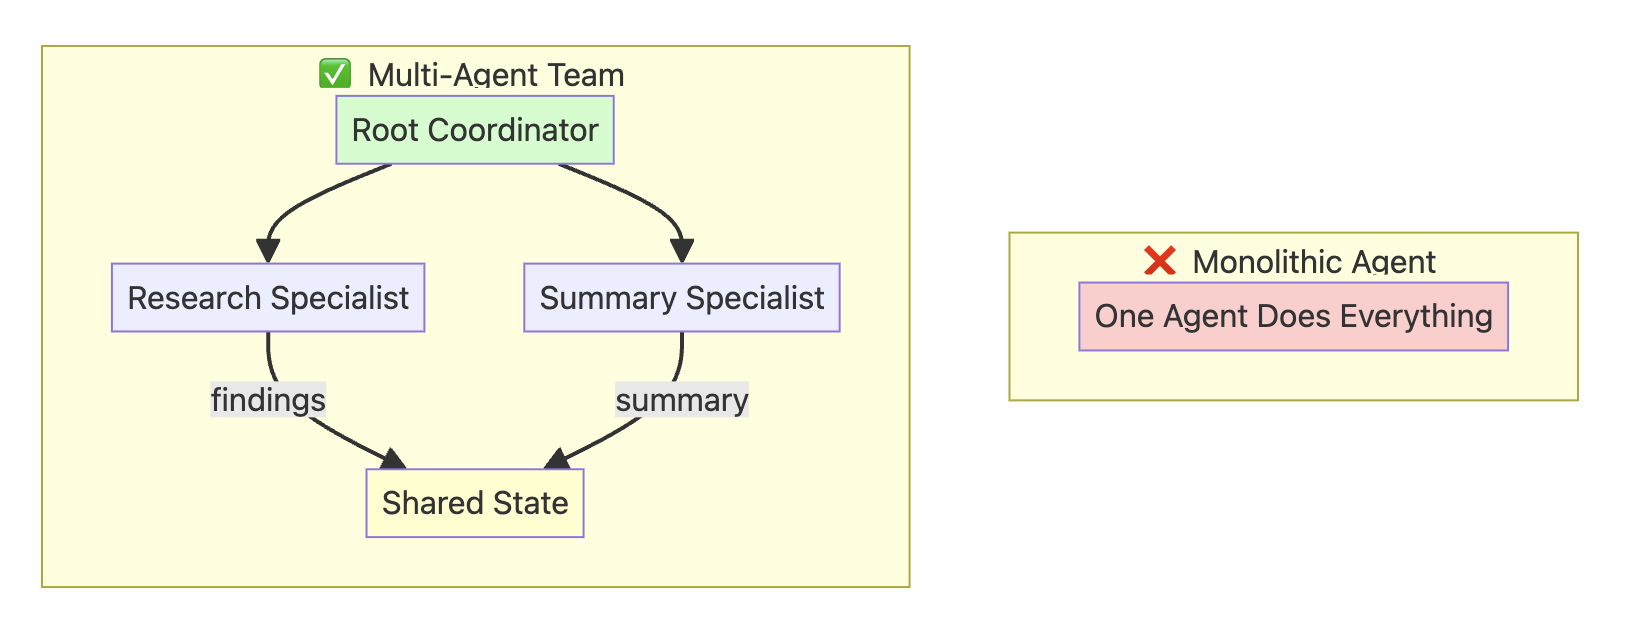!

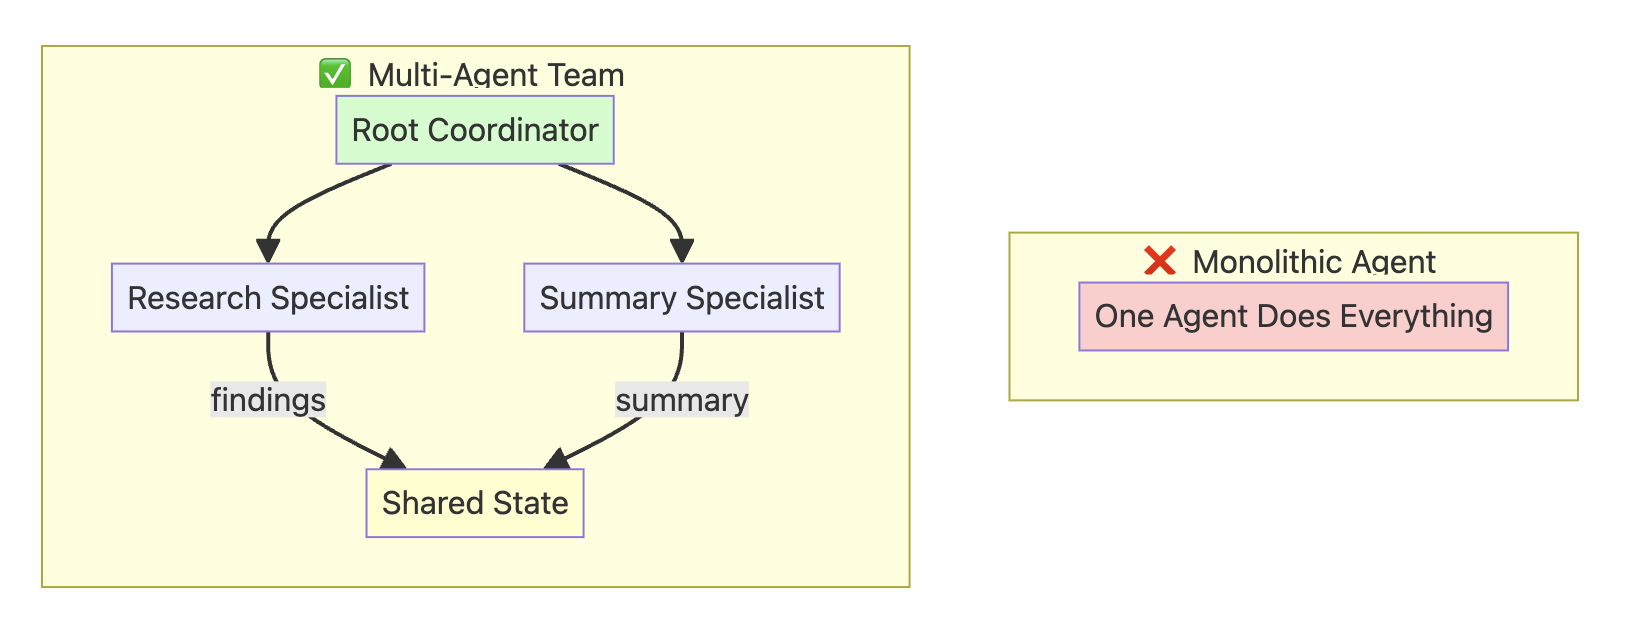

In [6]:
# Research Agent: Its job is to use the google_search tool and present findings.
research_agent = Agent(
    name="ResearchAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a specialized research agent. Your only job is to use the
    google_search tool to find 2-3 pieces of relevant information on the given topic and present the findings with citations.""",
    tools=[google_search],
    output_key="research_findings",  # The result of this agent will be stored in the session state with this key.
)

print("✅ research_agent created.")

✅ research_agent created.


In [7]:
# Summarizer Agent: Its job is to summarize the text it receives.
summarizer_agent = Agent(
    name="SummarizerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The instruction is modified to request a bulleted list for a clear output format.
    instruction="""Read the provided research findings: {research_findings}
Create a concise summary as a bulleted list with 3-5 key points.""",
    output_key="final_summary",
)

print("✅ summarizer_agent created.")

✅ summarizer_agent created.


In [8]:
#Root Coordinator : Orchestrates the workflow by calling the sub-agents as tools.

root_agent = Agent(
    name = "ResearchCoordinator",
    model = Gemini(
        model ="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    
    # This instruction tells the root agent HOW to use its tools (which are the other agents).
    instruction="""You are a research coordinator. Your goal is to answer the user's query by orchestrating a workflow.
1. First, you MUST call the `ResearchAgent` tool to find relevant information on the topic provided by the user.
2. Next, after receiving the research findings, you MUST call the `SummarizerAgent` tool to create a concise summary.
3. Finally, present the final summary clearly to the user as your response.""",
    
    # We wrap the sub-agents in `AgentTool` to make them callable tools for the root agent.
    tools=[AgentTool(research_agent), AgentTool(summarizer_agent)],
)

print("✅ root_agent created.")


✅ root_agent created.


Here we're using AgentTool to wrap the sub_agents to make them callable tools for the root agent we'll explore AgentTool in detail on day 2 

In [9]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "What are the latest advancements in quantum computing and what do they mean for AI?"
)


 ### Created new session: debug_session_id

User > What are the latest advancements in quantum computing and what do they mean for AI?


ResearchCoordinator > Quantum computing is poised to revolutionize artificial intelligence by offering exponential increases in computational power and efficiency, enabling AI to tackle previously insurmountable problems. This convergence, termed Quantum AI, holds the promise of faster, more precise, and more intelligent AI systems that can have a transformative impact across numerous industries.

Here's a concise summary of the latest advancements in quantum computing and their implications for AI:

*   **Enhanced AI Capabilities & Complex Problem-Solving:** Quantum computing, through principles like superposition and entanglement, offers exponential increases in computational power. This enables AI to train models faster, process larger datasets more efficiently, and tackle previously intractable problems in fields like drug discovery, materials science, and finance.
*   **Overcoming Classical Limitations & Data Efficiency:** Quantum AI promises more sustainable and efficient AI by p

You've just built your first multi-agent system! You used a single "coordinator" agent to manage the workflow, which is a powerful and flexible pattern.

‼️ However, relying on an LLM's instructions to control the order can sometimes be unpredictable. Next, we'll explore a different pattern that gives you guaranteed, step-by-step execution.

**🚥 Section 3: Sequential Workflows - The Assembly Line**


The Problem: Unpredictable Order

The previous multi-agent system worked, but it relied on a detailed instruction prompt to force the LLM to run steps in order. This can be unreliable. A complex LLM might decide to skip a step, run them in the wrong order, or get "stuck," making the process unpredictable


e Solution: A Fixed Pipeline

When you need tasks to happen in a guaranteed, specific order, you can use a SequentialAgent. This agent acts like an assembly line, running each sub-agent in the exact order you list them. The output of one agent automatically becomes the input for the next, creating a predictable and reliable workflow.

Use Sequential when: Order matters, you need a linear pipeline, or each step builds on the previous one.

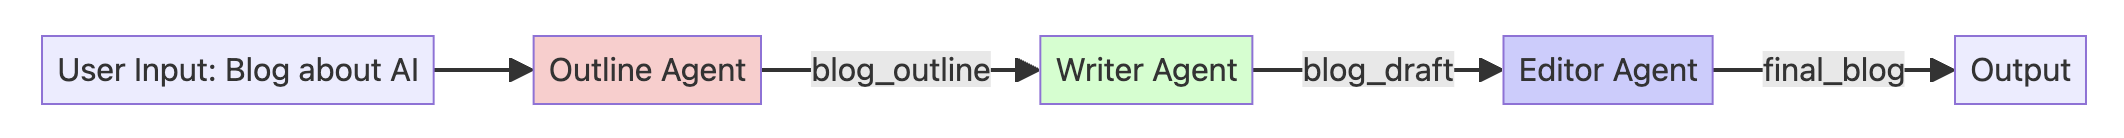

3.1 Example: 
**Blog Post Creation with Sequential Agents¶Let's build a system with three specialized agents:**


* **Outline Agent** - Creates a blog outline for a given topic
* **Writer Agent** - Writes a blog post
* **Editor Agent** - Edits a blog post draft for clarity and structure

In [10]:
# outline Agent: Creates the initial blog post outline
outline_agent = Agent(
    name = "OutLineAgent",
    model = Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction = """Create a blog outline for the given topic with:
    1. A catchy headline
    2. An introduction hook
    3. 3-5 main sections with 2-3 bullet points for each
    4. A concluding thought""",
    output_key="blog_outline",  # The result of this agent will be stored in the session state with this key.
)

print("✅ outline_agent created.")


✅ outline_agent created.


In [11]:
# Writer Agent :Writes the full blog post on the outline from the previous agnet
writer_agent = Agent(
    name = "WriterAgent",
    model= Gemini(
        model = "gemini-2.5-flash-lite",
        retry_optrions = retry_config
    ),
    # the {blog_outline}, placholder automatically injects the state value 
    # from the previous agnet's output.

        instruction = """Following this outline strictly: {blog_outline}
    Write a brief, 200 to 300-word blog post with an engaging and informative tone.""",
    output_key = "blog_draft", 
    # the result of this agent will be stored with this key.
)

print("✅ writer_agent created.")


✅ writer_agent created.


In [12]:
# Editor Agent: Edits and polishes the draft from the writer agent.
editor_agent = Agent(
    name="EditorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This agent receives the `{blog_draft}` from the writer agent's output.
    instruction="""Edit this draft: {blog_draft}
    Your task is to polish the text by fixing any grammatical errors, improving the flow and sentence structure, and enhancing overall clarity.""",
    output_key="final_blog",  
    # This is the final output of the entire pipeline.
)

print("✅ editor_agent created.")

✅ editor_agent created.


In [13]:
root_agent = SequentialAgent(
    name="BlogPipeline",
    sub_agents=[outline_agent, writer_agent, editor_agent],
)

print("✅ Sequential Agent created.")

✅ Sequential Agent created.


In [14]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
"Write a blog post about the benefits of multi-agent systems for software developers"
)


 ### Created new session: debug_session_id

User > Write a blog post about the benefits of multi-agent systems for software developers
OutLineAgent > ## Blog Outline: Unleashing Superpowers: How Multi-Agent Systems Revolutionize Software Development

**Introduction Hook:**

Ever feel like your software projects are battling a hydra of complexity? Introducing multi-agent systems (MAS) – a revolutionary approach where intelligent, autonomous agents collaborate to tackle tasks. Imagine a team of tiny, specialized workers, each with its own brain, working together seamlessly. This isn't science fiction; it's the future of software development, and it's here to empower you.

**Main Sections:**

**1. The Power of Specialization: Divide and Conquer with Precision**

*   **Hyper-Focused Expertise:** Each agent can be designed and trained for a specific, granular task (e.g., data validation, UI rendering, authentication). This allows for highly optimized performance and reduced cognitive load 

👏 Great job! You've now created a reliable "assembly line" using a sequential agent, where each step runs in a predictable order.

This is perfect for tasks that build on each other, but it's slow if the tasks are independent. Next, we'll look at how to run multiple agents at the same time to speed up your workflow.

**🛣️ Section 4: Parallel Workflows - Independent Researchers**

The Problem:**The Bottleneck**

The previous sequential agent is great, but it's an assembly line. Each step must wait for the previous one to finish. What if you have several tasks that are not dependent on each other? For example, researching three different topics. Running them in sequence would be slow and inefficient, creating a bottleneck where each task waits unnecessarily.


he Solution: **Concurrent Execution**

When you have independent tasks, you can run them all at the same time using a ParallelAgent. This agent executes all of its sub-agents concurrently, dramatically speeding up the workflow. Once all parallel tasks are complete, you can then pass their combined results to a final 'aggregator' step.

**Use Parallel when: Tasks are independent, speed matters, and you can execute concurrently.**

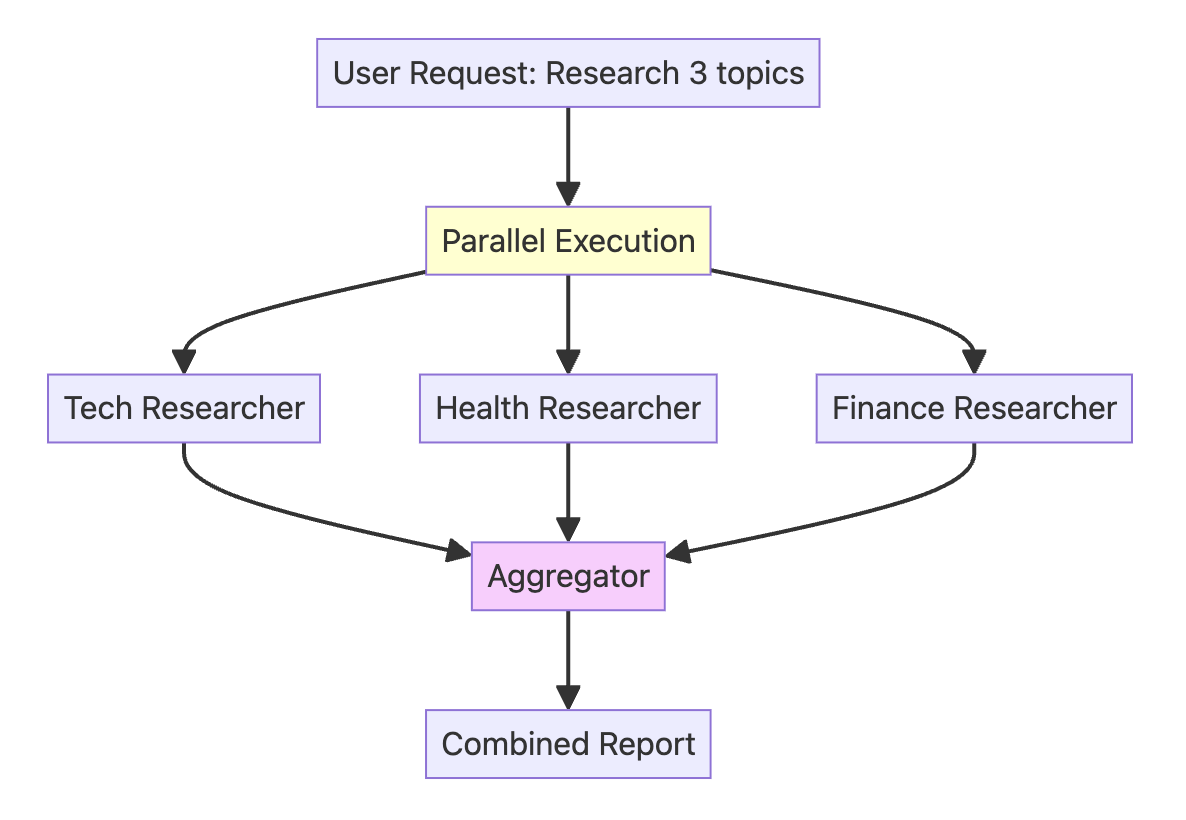

4.1 Example: **Parallel Multi-Topic Research**

*  Tech Researcher - Researches AI/ML news and trends
*  Health Researcher - Researches recent medical news and trends
*  Finance Researcher - Researches finance and fintech news and trends
*  Aggregator Agent - Combines all research findings into a single summary





In [15]:
# Tech Researcher: Focuses on AI and ML trends.
tech_researcher = Agent(
    name="TechResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research the latest AI/ML trends. Include 3 key developments,
the main companies involved, and the potential impact. Keep the report very concise (100 words).""",
    tools=[google_search],
    output_key="tech_research",  # The result of this agent will be stored in the session state with this key.
)

print("✅ tech_researcher created.")

✅ tech_researcher created.


In [16]:
# Health Researcher: Focuses on medical breakthroughs.
health_researcher = Agent(
    name="HealthResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research recent medical breakthroughs. Include 3 significant advances,
their practical applications, and estimated timelines. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="health_research",  # The result will be stored with this key.
)

print("✅ health_researcher created.")

✅ health_researcher created.


In [17]:
# Finance Researcher: Focuses on fintech trends.
finance_researcher = Agent(
    name="FinanceResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research current fintech trends. Include 3 key trends,
their market implications, and the future outlook. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="finance_research",  # The result will be stored with this key.
)

print("✅ finance_researcher created.")

✅ finance_researcher created.


In [18]:
# The AggregatorAgent runs *after* the parallel step to synthesize the results.
aggregator_agent = Agent(
    name="AggregatorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # It uses placeholders to inject the outputs from the parallel agents, which are now in the session state.
    instruction="""Combine these three research findings into a single executive summary:

    **Technology Trends:**
    {tech_research}
    
    **Health Breakthroughs:**
    {health_research}
    
    **Finance Innovations:**
    {finance_research}
    
    Your summary should highlight common themes, surprising connections, and the most important key takeaways from all three reports. The final summary should be around 200 words.""",
    output_key="executive_summary",  # This will be the final output of the entire system.
)

print("✅ aggregator_agent created.")

✅ aggregator_agent created.


👉 Then we bring the agents together under a parallel agent, which is itself nested inside of a sequential agent.

This design ensures that the research agents run first in parallel, then once all of their research is complete, the aggregator agent brings together all of the research findings into a single report:

In [19]:
# The ParallelAgent runs all its sub-agents simultaneously.

parallel_research_team = ParallelAgent(
    name="ParallelResearchTeam",
    sub_agents=[tech_researcher, health_researcher, finance_researcher],
)

# This SequentialAgent defines the high-level workflow: run the parallel team first, then run the aggregator.
root_agent = SequentialAgent(
    name="ResearchSystem",
    sub_agents=[parallel_research_team, aggregator_agent],
)

print("✅ Parallel and Sequential Agents created.")

✅ Parallel and Sequential Agents created.


In [20]:
runner = InMemoryRunner(agent= root_agent)
response = await runner.run_debug(
    "Run  the daily executive briefing on the Tech , health, finance"
)


 ### Created new session: debug_session_id

User > Run  the daily executive briefing on the Tech , health, finance
HealthResearcher > Here are three significant medical breakthroughs with their applications and estimated timelines:

1.  **CRISPR Gene Editing**: This technology allows for precise modifications to DNA.
    *   **Applications**: Treating genetic diseases, developing new crops, and advancing biotechnology.
    *   **Timeline**: Ongoing development with significant clinical applications emerging in the next 5-10 years.

2.  **mRNA Vaccine Technology**: Revolutionized by COVID-19 vaccines, this platform enables rapid vaccine development.
    *   **Applications**: Vaccines for various infectious diseases, and potential applications in cancer therapies.
    *   **Timeline**: Already in use, with wider applications and new vaccine types expected within the next 5 years.

3.  **AI in Diagnostics and Drug Discovery**: Artificial intelligence is enhancing the speed and accuracy o

Great! you've seen how parallel agnet can dramatically speed up workflows by running independent tasks concurrently.

so far all our workfloes run from start to finish and then stop, **but what if you need to review and imporve an output multiple times**? next, we'll build a workflow that can loop and refine its own work.

**➰  Section 5: loop Workflows - The Refinement Cycle**

**The Problem: One-Shot Quality**

All the workflows we've seen so far run from start to finish. The SequentialAgent and ParallelAgent produce their final output and then stop. This 'one-shot' approach isn't good for tasks that require refinement and quality control. What if the first draft of our story is bad? We have no way to review it and ask for a rewrite.

**The Solution: Iterative Refinement**

When a task needs to be improved through cycles of feedback and revision, you can use a LoopAgent. A LoopAgent runs a set of sub-agents repeatedly until a specific condition is met or a maximum number of iterations is reached. This creates a refinement cycle, allowing the agent system to improve its own work over and over.

**Use Loop when: Iterative improvement is needed, quality refinement matters, or you need repeated cycles.**


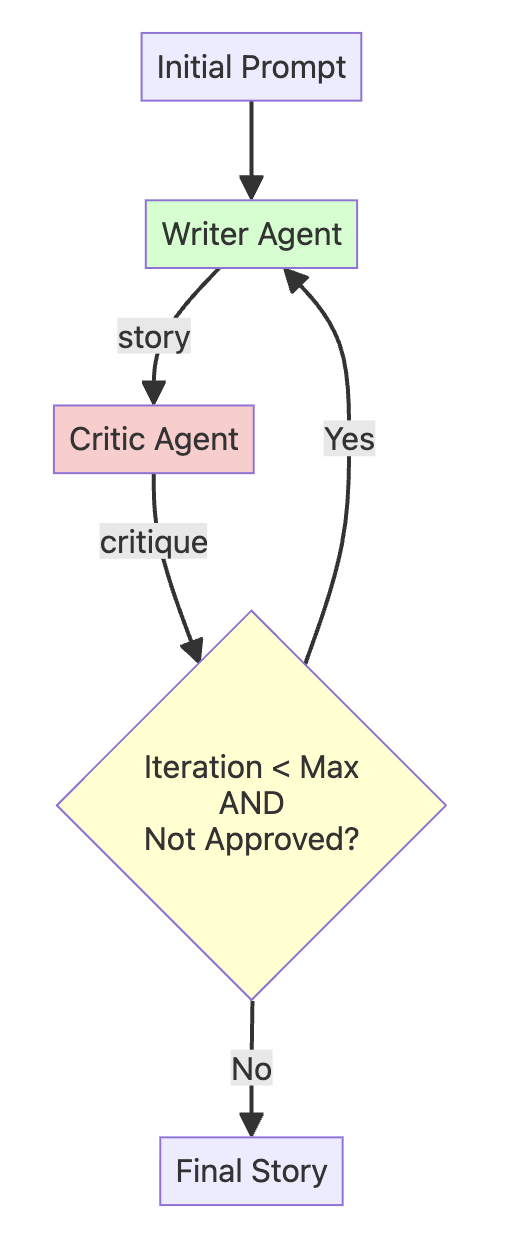

**Iterative Story Refinement**
Let's build a system with two agents:

**Writer Agent** - Writes a draft of a short story

**Critic Agent** - Reviews and critiques the short story to suggest improvements

In [21]:
# this agent runs once at the beginning to create the first draft

initial_writer_agent = Agent(
    name = "InitialWriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
     instruction = """Based on the user's prompt, write the first draft of a short story (around 100-150 words).
    Output only the story text, with no introduction or explanation.""",

     output_key = "current_story",
     # stores the first draft in the state.
)
print("✅ initial_writer_agent created.")


✅ initial_writer_agent created.


In [23]:
# this agent's only job is to provide feedback or the a approvel singe.  it has no tools.

critic_agent = Agent(
    name = "CriticAgent",
    model = Gemini(
        model = "gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction ="""You are a constructive story critic. Review the story provided below.
    Story: {current_story}
    
    Evaluate the story's plot, characters, and pacing.
    - If the story is well-written and complete, you MUST respond with the exact phrase: "APPROVED"
    - Otherwise, provide 2-3 specific, actionable suggestions for improvement.""",
    output_key="critique",  # Stores the feedback in the state.
)

print("✅ critic_agent created.")



✅ critic_agent created.


Now, we need a way for the loop to actually stop based on the critic's feedback. The *LoopAgent* itself doesn't automatically **know that "APPROVED" means "stop."**

We need an agent to give it an explicit signal to terminate the loop.

We do this in two parts:

* A simple Python function that the LoopAgent understands as an "exit" signal.
* An agent that can call that function when the right condition is met.

  
**First, you'll define the exit_loop function:**

In [25]:
# this is th efunction that the RefinerAgent will call to ecit the loop

def exit_loop():
    """Call this function ONLY when the critique is 'APPROVED', indicating 
    the story is finished and no more changes are needed."""
    return {"status": "approved", "message": "Story approved. Exiting refinement loop."}
    

print("✅ exit_loop function created.")



✅ exit_loop function created.


To let an agent call this Python function, we wrap it in a FunctionTool. Then, we create a RefinerAgent that has this tool.

👉 **Notice its instructions**: this agent is the "**brain**" of the loop.
It reads the *{critique}* from the CriticAgent and decides whether to (1) call the *exit_loop* tool or (2) rewrite the story

In [26]:
# This agent refines the story based on critique OR calls the exit_loop function.
refiner_agent = Agent(
    name="RefinerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a story refiner. You have a story draft and critique.
    
    Story Draft: {current_story}
    Critique: {critique}
    
    Your task is to analyze the critique.
    - IF the critique is EXACTLY "APPROVED", you MUST call the `exit_loop` function and nothing else.
    - OTHERWISE, rewrite the story draft to fully incorporate the feedback from the critique.""",
    output_key="current_story",  # It overwrites the story with the new, refined version.
    tools=[
        FunctionTool(exit_loop)
    ],  # The tool is now correctly initialized with the function reference.
)

print("✅ refiner_agent created.")

✅ refiner_agent created.


Then we bring the agents together under a loop agent, which is itself nested inside of a sequential agent.

This design ensures that the system first produces an initial story draft, then the refinement loop runs up to the specified number of max_iterations:

In [27]:
# The LoopAgent contains the agents that will run repeatedly: Critic -> Refiner.
story_refinement_loop = LoopAgent(
    name="StoryRefinementLoop",
    sub_agents=[critic_agent, refiner_agent],
    max_iterations=2,  # Prevents infinite loops
)

# The root agent is a SequentialAgent that defines the overall workflow: Initial Write -> Refinement Loop.
root_agent = SequentialAgent(
    name="StoryPipeline",
    sub_agents=[initial_writer_agent, story_refinement_loop],
)

print("✅ Loop and Sequential Agents created.")

✅ Loop and Sequential Agents created.


**Let's run the agent and give it a topic to write a short story**

In [28]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "Write a short story about a lighthouse keeper who discovers a mysterious, glowing map"
) 


 ### Created new session: debug_session_id

User > Write a short story about a lighthouse keeper who discovers a mysterious, glowing map
InitialWriterAgent > The salt spray kissed Elias’s weathered face as he climbed the spiral stairs, the familiar groan of the lantern room his only companion. For twenty years, he’d tended the Flame of Atheria, a beacon against the treacherous shoals. Tonight, a storm brewed, the sea a restless beast. As he stoked the lamp, his boot nudged a loose floorboard. Beneath it, nestled in the dust, lay a rolled parchment.

Unfurling it, Elias gasped. It wasn't paper, but some luminous, silken material. Etched upon it, in lines of phosphorescent ink, was a map. Not of any coast he knew, but of shimmering constellations, dotted with symbols that pulsed with an inner light. A single, radiant 'X' marked a point far beyond the known stars.
CriticAgent > The plot is intriguing, hinting at a grander mystery beyond Elias's solitary life. The pacing is good, quickly 


**Section 6:** Summary - Choosing the Right Pattern


Decision Tree: Which Workflow Pattern?

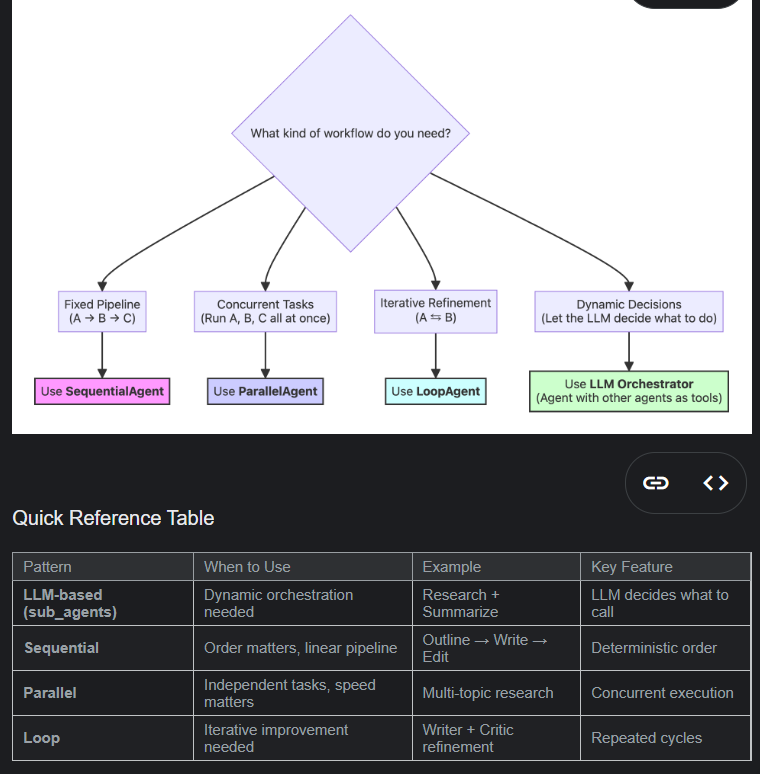

In this notebook, you made the leap from a single agent to a multi-agent system.

**You saw why a team of specialists is easier to build and debug than one "do-it-all" agent. Most importantly, you learned how to be the director of that team.**

You used **SequentialAgent, ParallelAgent**, and **LoopAgent** to create deterministic workflows, and you even used an LLM as a 'manager' to make dynamic decisions. You also mastered the "plumbing" by using *output_key* to pass state between agents and make them collaborative.